# Quantify workflow & job reruns in GHA

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import pickle
import numpy as np
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
from tools.empirical import *

from ast import literal_eval

## Load the data for workflow & job reruns

In [2]:
df_workflow_rerun = pd.read_csv('../data/dataframes/dataframe_workflow_rerun_distinct.csv.gz', index_col=0, converters={'reruns ids':literal_eval, 'reruns':literal_eval, "last rerun's conclusion":literal_eval})
df_job_rerun = pd.read_csv('../data/dataframes/dataframe_job_rerun_distinct.csv.gz', index_col=0, converters={'reruns ids':literal_eval, 'reruns':literal_eval, "last rerun's conclusion":literal_eval})

In [3]:
df_workflow_rerun

,File index,repo path,workflow file path,branch,default,event,reruns,reruns ids,# avg rerun,# max rerun,# min rerun,# rerun sets,last rerun's conclusion,# success,# failure,content,rerun conclusion
0,"[3, 3, 1]",1c-syntax/bsl-language-server,.github/workflows/qa.yml,develop,True,"[['workflow_run', 'workflow_run', 'workflow_ru...","[2, 19, 7, 3, 3, 5, 6, 8, 2, 9, 1, 1]","[[6174675977, 6174737838, 6174898363], [644200...",5.500000,19,1,12,"[success, success, success, success, success, ...",7,5,[['https://api.github.com/repos/1c-syntax/bsl-...,"[['failure', 'success', 'success'], ['failure'..."
1,"[3, 14, 0]",1c-syntax/bsl-language-server,.github/workflows/gradle.yml,feature/osClassModuleType,False,"[['push', 'pull_request']]",[1],"[[5694924874, 5694924932]]",1.000000,1,1,1,[failure],0,1,[['https://api.github.com/repos/1c-syntax/bsl-...,"[['failure', 'failure']]"
2,"[4, 1, 0]",1c-syntax/sonar-bsl-plugin-community,.github/workflows/night_build.yml,develop,True,"[['schedule', 'schedule', 'schedule'], ['sched...","[2, 3, 7, 6, 3, 2, 4, 18, 1, 13, 1]","[[3827335175, 3835710330, 3844383153], [385315...",5.454545,18,1,11,"[failure, failure, failure, failure, failure, ...",0,11,[['https://api.github.com/repos/1c-syntax/sona...,"[['failure', 'failure', 'failure'], ['failure'..."
3,"[8, 2, 0]",3arthqu4ke/3arthh4ck,.github/workflows/docker.yml,main,True,"[['workflow_run', 'workflow_run']]",[1],"[[4076411830, 4091899320]]",1.000000,1,1,1,[success],1,0,[['https://api.github.com/repos/3arthqu4ke/3ar...,"[['failure', 'success']]"
4,"[12, 11, 1]",94fzb/zrlog,.github/workflows/codeql-analysis.yml,master,True,"[['schedule', 'schedule', 'schedule', 'schedul...","[8, 2, 3, 3]","[[3872519179, 3929066488, 3985101351, 40424906...",4.000000,8,2,4,"[success, success, success, success]",4,0,[['https://api.github.com/repos/94fzb/zrlog/co...,"[['failure', 'success', 'success', 'failure', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,"[3308, 4, 0]",zhouhailin/freeswitch-externals,dynamic/pages/pages-build-deployment,v1.7-dev,True,"[['dynamic', 'dynamic', 'dynamic']]",[2],"[[5123044637, 5123054258, 6582462821]]",2.000000,2,2,1,[success],1,0,[['https://api.github.com/repos/zhouhailin/fre...,"[['failure', 'success', 'success']]"
1368,"[3310, 2, 1]",zinggAI/zingg,.github/workflows/codeql.yml,0.3.5,False,"[['push', 'push']]",[1],"[[4581579825, 4626574290]]",1.000000,1,1,1,[failure],0,1,[['https://api.github.com/repos/zinggAI/zingg/...,"[['failure', 'failure']]"
1369,"[3310, 10, 1]",zinggAI/zingg,.github/workflows/codeql.yml,main,True,"[['push', 'schedule'], ['push', 'push'], ['pus...","[1, 1, 1, 7, 2, 1, 2, 2, 3, 3, 4, 3, 8, 4]","[[4375112804, 4381093887], [4550952813, 455098...",3.000000,8,1,14,"[failure, failure, failure, failure, failure, ...",0,14,[['https://api.github.com/repos/zinggAI/zingg/...,"[['failure', 'failure'], ['failure', 'failure'..."
1370,"[3314, 29, 0]",zonkyio/embedded-database-spring-test,.github/workflows/test.yml,flyway-9.9-plus,False,"[['push', 'pull_request']]",[1],"[[7534009017, 7534061061]]",1.000000,1,1,1,[failure],0,1,[['https://api.github.com/repos/zonkyio/embedd...,"[['failure', 'failure']]"


## 1. Basic statistics

There are 6302 workflow rerun sets in total, 2137 succeed (33.9%); 3868 failed (61.4%).
There are 17034 job rerun sets in total, 12537 succeed (73.6%); 4075 failed (23.9%).


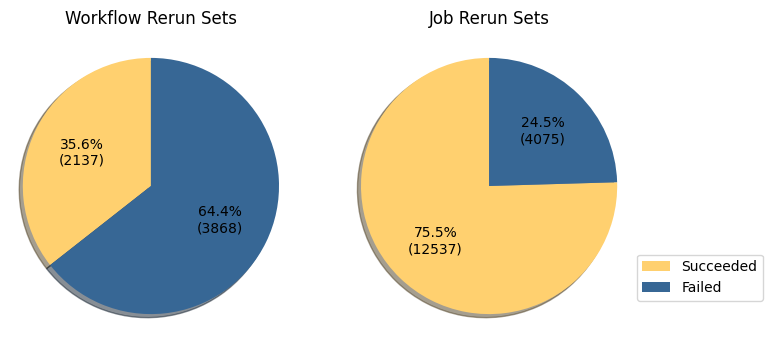

In [3]:
num_rerun_sets_w = df_workflow_rerun['# rerun sets'].sum()
num_rerun_sets_j = df_job_rerun['# rerun sets'].sum()
num_success_w = df_workflow_rerun['# success'].sum()
num_success_j = df_job_rerun['# success'].sum()
num_failure_w = df_workflow_rerun['# failure'].sum()
num_failure_j = df_job_rerun['# failure'].sum()
print(f'There are {num_rerun_sets_w} workflow rerun sets in total, {num_success_w} succeed ({round(num_success_w/num_rerun_sets_w*100,1)}%); {num_failure_w} failed ({round(num_failure_w/num_rerun_sets_w*100,1)}%).')
print(f'There are {num_rerun_sets_j} job rerun sets in total, {num_success_j} succeed ({round(num_success_j/num_rerun_sets_j*100,1)}%); {num_failure_j} failed ({round(num_failure_j/num_rerun_sets_j*100,1)}%).')


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return my_format

def visualization_piechart(data_1, data_2, labels):
    
    colors = [(255/255, 208/255, 111/255),(55/255, 103/255, 149/255)]

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    pie_1 = ax[0].pie(data_1, colors=colors, autopct=autopct_format(data_1), shadow=True, startangle=90)
    ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[0].set_title('Workflow Rerun Sets')

    pie_2 = ax[1].pie(data_2, colors=colors, autopct=autopct_format(data_2), shadow=True, startangle=90)
    ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[1].set_title('Job Rerun Sets')
    ax[1].legend(pie_2[0], labels, bbox_to_anchor=(1, 0.3))

    plt.show()
    
wf_sizes = [num_success_w, num_failure_w]
job_sizes = [num_success_j, num_failure_j]
labels = ['Succeeded', 'Failed']

visualization_piechart(wf_sizes,job_sizes,labels)

4942/6302 (78.4)% workflow rerun sets are within the default branch
11927/17034 (70.0)% job rerun sets are within the default branch


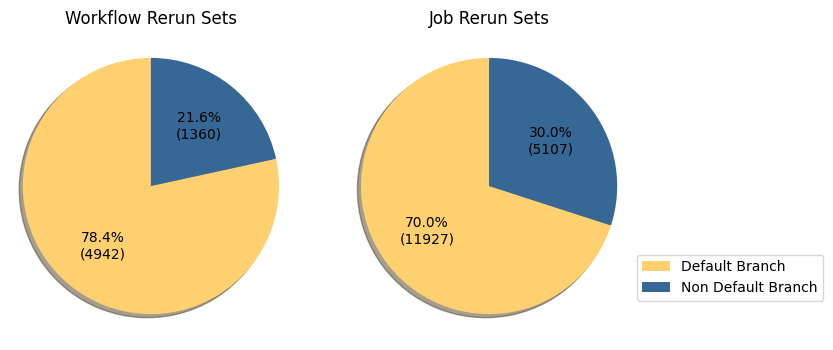

In [4]:
def count_rerun_sets_in_default_branch(branch_rerun_set):
    
    num_rerun_set = 0
    for b in branch_rerun_set: 
        num_rerun_set += b[0]*b[1]
    
    return num_rerun_set

branch_rerun_set_w = df_workflow_rerun[['default', '# rerun sets']].values.tolist()
branch_rerun_set_j = df_job_rerun[['default', '# rerun sets']].values.tolist()
num_rerun_default_w = count_rerun_sets_in_default_branch(branch_rerun_set_w)
num_rerun_default_j = count_rerun_sets_in_default_branch(branch_rerun_set_j)


print(f'{num_rerun_default_w}/{num_rerun_sets_w} ({round(num_rerun_default_w/num_rerun_sets_w*100,1)})% workflow rerun sets are within the default branch')
print(f'{num_rerun_default_j}/{num_rerun_sets_j} ({round(num_rerun_default_j/num_rerun_sets_j*100,1)})% job rerun sets are within the default branch')


wf_data = [num_rerun_default_w, num_rerun_sets_w-num_rerun_default_w]
job_data = [num_rerun_default_j, num_rerun_sets_j-num_rerun_default_j]
labels = ['Default Branch', 'Non Default Branch']

visualization_piechart(wf_data,job_data,labels)

In [5]:
avg_num_rerun_set_w = round(np.mean(df_workflow_rerun[['# rerun sets']].values.tolist()),1)
avg_num_rerun_set_j = round(np.mean(df_job_rerun[['# rerun sets']].values.tolist()),1)

max_num_rerun_set_w = np.max(df_workflow_rerun[['# rerun sets']].values.tolist())
max_num_rerun_set_j = np.max(df_job_rerun[['# rerun sets']].values.tolist())

print(f'On average {avg_num_rerun_set_w} workflow rerun sets per file.')
print(f'On average {avg_num_rerun_set_j} job rerun sets per file.')

print(f'Maximum workflow rerun sets per file: {max_num_rerun_set_w}')
print(f'Maximum job rerun sets per file: {max_num_rerun_set_j}')

On average 4.6 workflow rerun sets per file.
On average 4.0 job rerun sets per file.
Maximum workflow rerun sets per file: 106
Maximum job rerun sets per file: 368


In [6]:
def count_avg_rerun(avg_rerun_set):
    
    num_rerun = 0
    num_rerun_set = 0
    for a in avg_rerun_set: 
        num_rerun += a[0]*a[1]
        num_rerun_set += a[1]
    
    avg_num_rerun = round(num_rerun/num_rerun_set,2)
    #print(num_rerun_set)
    return avg_num_rerun

avg_rerun_set_w = df_workflow_rerun[['# avg rerun', '# rerun sets']].values.tolist()
avg_rerun_set_j = df_job_rerun[['# avg rerun', '# rerun sets']].values.tolist()
avg_w = count_avg_rerun(avg_rerun_set_w)
avg_j = count_avg_rerun(avg_rerun_set_j)


print(f'On average {avg_w} workflow reruns per rerun set.')
print(f'On average {avg_j} job reruns per rerun set.')

On average 7.89 workflow reruns per rerun set.
On average 1.27 job reruns per rerun set.


In [7]:
def max_num_reruns(df_rerun):
    
    max_rerun_list = df_rerun["# max rerun"]
    
    return max(max_rerun_list)

max_rerun_w = max_num_reruns(df_workflow_rerun)
max_rerun_j = max_num_reruns(df_job_rerun)

print(f'Maximum workflow reruns: {max_rerun_w}')
print(f'Maximum job reruns: {max_rerun_j}')

Maximum workflow reruns: 986
Maximum job reruns: 35


In [8]:
df_workflow_rerun

,File index,repo path,workflow file path,branch,default,event,reruns,reruns ids,# avg rerun,# max rerun,# min rerun,# rerun sets,last rerun's conclusion,# success,# failure,content,rerun conclusion
0,"[3, 3, 1]",1c-syntax/bsl-language-server,.github/workflows/qa.yml,develop,True,"[['workflow_run', 'workflow_run', 'workflow_ru...","[2, 19, 7, 3, 3, 5, 6, 8, 2, 9, 1, 1]","[[6174675977, 6174737838, 6174898363], [644200...",5.500000,19,1,12,"[success, success, success, success, success, ...",7,5,[['https://api.github.com/repos/1c-syntax/bsl-...,"[['failure', 'success', 'success'], ['failure'..."
1,"[3, 14, 0]",1c-syntax/bsl-language-server,.github/workflows/gradle.yml,feature/osClassModuleType,False,"[['push', 'pull_request']]",[1],"[[5694924874, 5694924932]]",1.000000,1,1,1,[failure],0,1,[['https://api.github.com/repos/1c-syntax/bsl-...,"[['failure', 'failure']]"
2,"[4, 1, 0]",1c-syntax/sonar-bsl-plugin-community,.github/workflows/night_build.yml,develop,True,"[['schedule', 'schedule', 'schedule'], ['sched...","[2, 3, 7, 6, 3, 2, 4, 18, 1, 13, 1]","[[3827335175, 3835710330, 3844383153], [385315...",5.454545,18,1,11,"[failure, failure, failure, failure, failure, ...",0,11,[['https://api.github.com/repos/1c-syntax/sona...,"[['failure', 'failure', 'failure'], ['failure'..."
3,"[8, 2, 0]",3arthqu4ke/3arthh4ck,.github/workflows/docker.yml,main,True,"[['workflow_run', 'workflow_run']]",[1],"[[4076411830, 4091899320]]",1.000000,1,1,1,[success],1,0,[['https://api.github.com/repos/3arthqu4ke/3ar...,"[['failure', 'success']]"
4,"[12, 11, 1]",94fzb/zrlog,.github/workflows/codeql-analysis.yml,master,True,"[['schedule', 'schedule', 'schedule', 'schedul...","[8, 2, 3, 3]","[[3872519179, 3929066488, 3985101351, 40424906...",4.000000,8,2,4,"[success, success, success, success]",4,0,[['https://api.github.com/repos/94fzb/zrlog/co...,"[['failure', 'success', 'success', 'failure', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,"[3308, 4, 0]",zhouhailin/freeswitch-externals,dynamic/pages/pages-build-deployment,v1.7-dev,True,"[['dynamic', 'dynamic', 'dynamic']]",[2],"[[5123044637, 5123054258, 6582462821]]",2.000000,2,2,1,[success],1,0,[['https://api.github.com/repos/zhouhailin/fre...,"[['failure', 'success', 'success']]"
1368,"[3310, 2, 1]",zinggAI/zingg,.github/workflows/codeql.yml,0.3.5,False,"[['push', 'push']]",[1],"[[4581579825, 4626574290]]",1.000000,1,1,1,[failure],0,1,[['https://api.github.com/repos/zinggAI/zingg/...,"[['failure', 'failure']]"
1369,"[3310, 10, 1]",zinggAI/zingg,.github/workflows/codeql.yml,main,True,"[['push', 'schedule'], ['push', 'push'], ['pus...","[1, 1, 1, 7, 2, 1, 2, 2, 3, 3, 4, 3, 8, 4]","[[4375112804, 4381093887], [4550952813, 455098...",3.000000,8,1,14,"[failure, failure, failure, failure, failure, ...",0,14,[['https://api.github.com/repos/zinggAI/zingg/...,"[['failure', 'failure'], ['failure', 'failure'..."
1370,"[3314, 29, 0]",zonkyio/embedded-database-spring-test,.github/workflows/test.yml,flyway-9.9-plus,False,"[['push', 'pull_request']]",[1],"[[7534009017, 7534061061]]",1.000000,1,1,1,[failure],0,1,[['https://api.github.com/repos/zonkyio/embedd...,"[['failure', 'failure']]"


Conclusions found in workflow reruns:


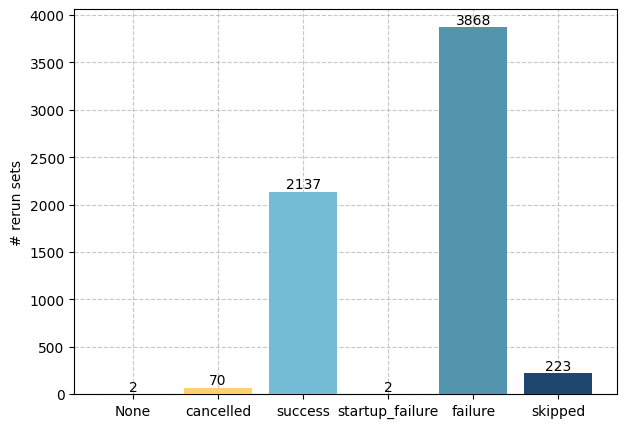

Conclusions found in job reruns:


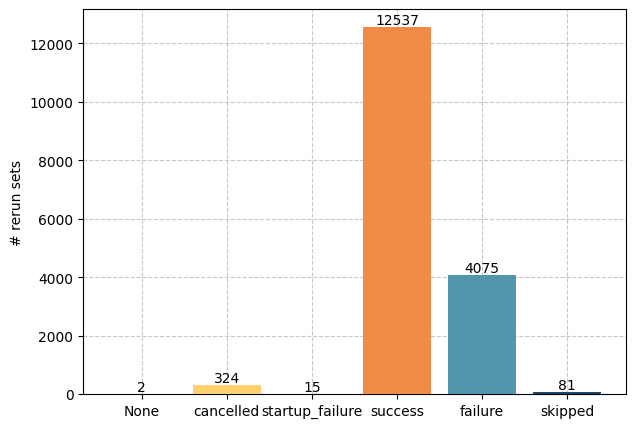

In [9]:
def analyze_conclusion(df_rerun):
    
    conclusion_list = df_rerun["last rerun's conclusion"]
    all_con = []
    counts = []
    
    for con in conclusion_list:
        all_con.extend(con)

    taxonomy_con = list(set(all_con))
    for state in taxonomy_con:
        
        counts.append(all_con.count(state))
        
    keys = [str(t) for t in taxonomy_con]
    
    colors = [
    (231/255, 98/255, 84/255),
    (255/255, 208/255, 111/255),
    (114/255, 188/255, 213/255),
    (239/255, 138/255, 71/255),
    (82/255, 149/255, 173/255),
    (30/255, 70/255, 110/255)
    ]
    
    plt.figure(figsize=(7, 5))
    plt.grid(True, linestyle='--', alpha=0.7, zorder=0)
    plt.bar(keys, counts, color=colors, zorder=10)

    plt.ylabel('# rerun sets')
    plt.xticks(keys)

    for i, value in enumerate(counts):
        plt.text(keys[i], value, str(value), ha='center', va='bottom')

    plt.show()
    
    
print("Conclusions found in workflow reruns:")
analyze_conclusion(df_workflow_rerun)
print("Conclusions found in job reruns:")
analyze_conclusion(df_job_rerun)

## 2. Visualization 
### 2.1 Rerun set proportion

In [10]:
def visualization_proportion(x_w, x_j, y_w, y_j, acc_x_w, acc_x_j, acc_y_w, acc_y_j, granularity, percent_labels, percent_position, position_labels, position_lines, labels, saving_path=None):
    
    colors = [(255/255, 208/255, 111/255),(55/255, 103/255, 149/255)]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    width = 0.4
    yticks = [i * 0.1 for i in range(11)]


    ax[0].bar(x_w - width/2, y_w, width, label=labels[0], color=colors[1])
    ax[0].bar(x_j + width/2, y_j, width, label=labels[1], color=colors[0])

    ax[0].set_xlabel(f'a)  # {granularity[0]}s per {granularity[1]}')
    ax[0].set_ylabel(f'Proportion of {granularity[1]}s')
    ax[0].set_xlim(0, 25)
    ax[0].set_ylim(0, 1)
    ax[0].set_yticks(yticks)

    ax[0].grid(True, linestyle='--', alpha=0.7)
    ax[0].text(1.6, percent_position[0], percent_labels[0], color='black', fontsize=10, ha='left', va='top',bbox=dict(facecolor=colors[0], edgecolor=colors[0], pad=1))
    ax[0].text(1.3, percent_position[1], percent_labels[1], color='black', fontsize=10, ha='left', va='top',bbox=dict(facecolor=colors[1], edgecolor=colors[1], pad=1))

    ax[0].legend()

    ax[1].plot(acc_x_w, acc_y_w, marker='o', label='Workflow rerun', color=colors[1], zorder=5)
    ax[1].plot(acc_x_j, acc_y_j, marker='o', label='Job rerun', color=colors[0], zorder=4)

    ax[1].set_xlabel(f'b)  # {granularity[0]}s per {granularity[1]}')
    ax[1].set_ylabel(f'Cumulative proportion of {granularity[1]}s')

    ax[1].set_xlim(0, 25)
    ax[1].set_ylim(0, 1.02)
    ax[1].set_yticks(yticks)
    ax[1].grid(True, linestyle='--', alpha=0.7, zorder=0)

    ax[1].axvline(x=position_lines[0], color='dimgray', linestyle='--', linewidth=1, zorder=1)
    ax[1].axvline(x=position_lines[1], color='dimgray', linestyle='--', linewidth=1, zorder=1)
    ax[1].axhline(y=0.9, color='dimgray', linestyle='-', linewidth=1, zorder=3)

    ax[1].text(position_lines[0]+0.3, position_labels[0], f'{position_lines[0]} reruns', color='black', fontsize=10, ha='left', va='top',bbox=dict(facecolor=colors[0], edgecolor=colors[0], pad=1))
    ax[1].text(position_lines[1]+0.3, position_labels[1], f'{position_lines[1]} reruns', color='black', fontsize=10, ha='left', va='top',bbox=dict(facecolor=colors[1], edgecolor=colors[1], pad=1))

    ax[1].legend(loc='lower right')


    # Save the plot as a vector plot (PDF)
    if saving_path:
        
        plt.savefig(saving_path, format='pdf', bbox_inches='tight')
        
    plt.show()


In [11]:
def find_rerun_proportion(df_rerun):

    reruns = df_rerun['reruns'].values.tolist()

    rerun_nums = defaultdict(int)

    n_rerun_set = 0
    
    for file in reruns:
        for rerun in file:
            rerun_nums[rerun] += 1
            n_rerun_set += 1

    proportion = OrderedDict(sorted(rerun_nums.items()))

    x = np.array(list(proportion.keys()))
    y = np.array(list(proportion.values()))/n_rerun_set
    
    return x, y


x_w, y_w = find_rerun_proportion(df_workflow_rerun)
x_j, y_j = find_rerun_proportion(df_job_rerun)

acc_y_w = [sum(y_w[:i]) for i in range(len(y_w))]
acc_y_j = [sum(y_j[:i]) for i in range(len(y_j))]
acc_x_w = np.array([0] + list(x_w[:-1]))
acc_x_j = np.array([0] + list(x_j[:-1]))

avg_w = sum(np.multiply(x_w, y_w))
avg_j = sum(np.multiply(x_j, y_j))

print(f'On average, a workflow rerun set contains {round(avg_w,1)} reruns.')
print(f'On average, a job rerun set contains {round(avg_j,1)} reruns.')

On average, a workflow rerun set contains 7.9 reruns.
On average, a job rerun set contains 1.3 reruns.


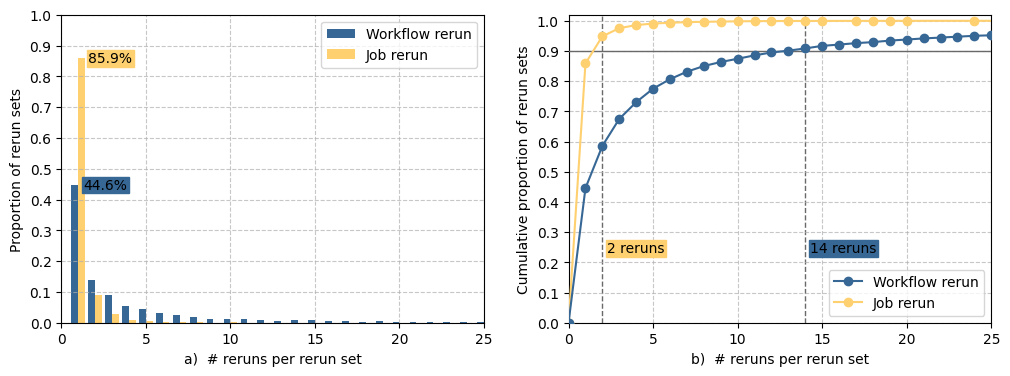

In [12]:
position_labels = [0.27, 0.27]
position_lines = [2, 14]
percent_labels = ['85.9%','44.6%']
percent_position = [0.88, 0.47]
labels = ['Workflow rerun','Job rerun']
granularity = ['rerun', 'rerun set']
visualization_proportion(x_w, x_j, y_w, y_j, acc_x_w, acc_x_j, acc_y_w, acc_y_j, granularity, percent_labels, percent_position, position_labels, position_lines, labels, '../plots/proportion_r_set.pdf')

### 2.2 Successful rerun set proportion (With last run's conclusion == 'success')

In [13]:
def find_rerun_success_proportion(df_rerun):

    reruns = df_rerun[["reruns","last rerun's conclusion"]].values.tolist()

    rerun_nums = defaultdict(int)

    n_rerun_set = 0
    
    for file in reruns:
        for idr, rerun in enumerate(file[0]):
            if file[1][idr] == 'success':
                rerun_nums[rerun] += 1
                n_rerun_set += 1

    proportion = OrderedDict(sorted(rerun_nums.items()))

    x = np.array(list(proportion.keys()))
    y = np.array(list(proportion.values()))/n_rerun_set
    
    return x, y


x_w, y_w = find_rerun_success_proportion(df_workflow_rerun)
x_j, y_j = find_rerun_success_proportion(df_job_rerun)

acc_y_w = [sum(y_w[:i]) for i in range(len(y_w))]
acc_y_j = [sum(y_j[:i]) for i in range(len(y_j))]
acc_x_w = np.array([0] + list(x_w[:-1]))
acc_x_j = np.array([0] + list(x_j[:-1]))

avg_w = sum(np.multiply(x_w, y_w))
avg_j = sum(np.multiply(x_j, y_j))

print(f'On average, a successful workflow rerun set contains {round(avg_w,1)} reruns.')
print(f'On average, a successful job rerun set contains {round(avg_j,1)} reruns.')

On average, a successful workflow rerun set contains 11.6 reruns.
On average, a successful job rerun set contains 1.3 reruns.


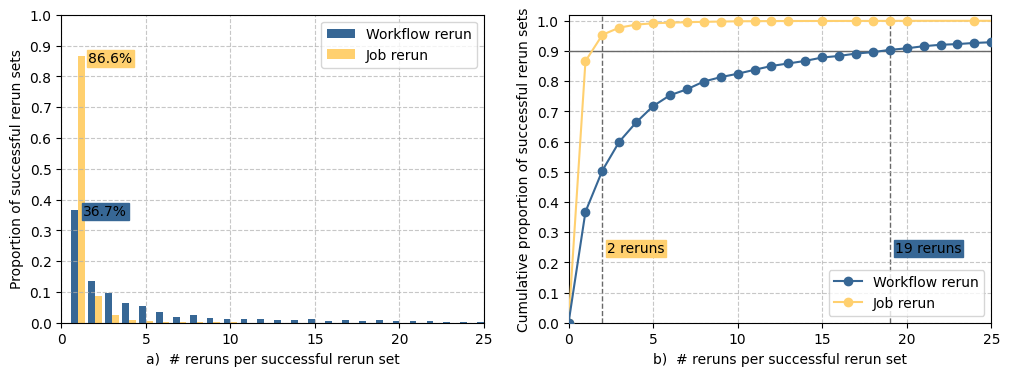

In [14]:
position_labels = [0.27, 0.27]
position_lines = [2, 19]
percent_labels = ['86.6%','36.7%']
percent_position = [0.88, 0.385]
granularity = ['rerun', 'successful rerun set']
visualization_proportion(x_w, x_j, y_w, y_j, acc_x_w, acc_x_j, acc_y_w, acc_y_j, granularity, percent_labels, percent_position, position_labels, position_lines, labels, '../plots/proportion_r_set_success.pdf')

### 2.3 Worlflow file proportion

In [15]:
def find_set_proportion(df_rerun):

    rerun_sets = df_rerun['# rerun sets'].values.tolist()

    set_nums = defaultdict(int)

    n_file = 0
    
    for r_set in rerun_sets:
        set_nums[r_set] += 1
        n_file += 1

    proportion = OrderedDict(sorted(set_nums.items()))

    x = np.array(list(proportion.keys()))
    y = np.array(list(proportion.values()))/n_file
    
    return x, y


x_w, y_w = find_set_proportion(df_workflow_rerun)
x_j, y_j = find_set_proportion(df_job_rerun)

acc_y_w = [sum(y_w[:i]) for i in range(len(y_w))]
acc_y_j = [sum(y_j[:i]) for i in range(len(y_j))]
acc_x_w = np.array([0] + list(x_w[:-1]))
acc_x_j = np.array([0] + list(x_j[:-1]))

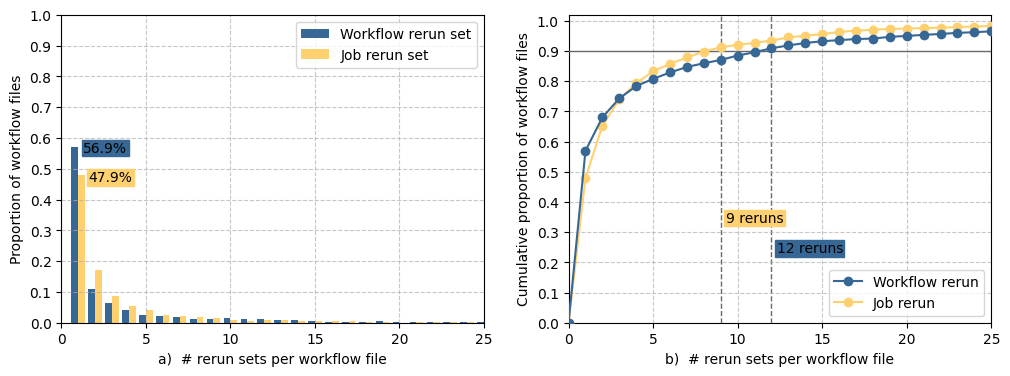

In [23]:
position_labels = [0.37, 0.27]
position_lines = [9, 12]
percent_labels = ['47.9%','56.9%']
percent_position = [0.495, 0.59]
granularity = ['rerun set', 'workflow file']
labels = ['Workflow rerun set', 'Job rerun set']
visualization_proportion(x_w, x_j, y_w, y_j, acc_x_w, acc_x_j, acc_y_w, acc_y_j, granularity, percent_labels, percent_position, position_labels, position_lines, labels, '../plots/proportion_wf_file.pdf')

## 3. Calculate Waiting & Computational time wasted on workflow reruns

In [17]:
df_workflow_rerun = pd.read_csv('../data/dataframes/dataframe_workflow_rerun_totalduration_runtime_distinct.csv.gz', index_col=0, converters={'total duration':literal_eval, 'run time':literal_eval, "last rerun's conclusion":literal_eval})
reruns_time_list =  df_workflow_rerun[["last rerun's conclusion",'total duration','run time']].values.tolist()

In [18]:
waiting_time = []
computational_time = []

waiting_time_success = []
computational_time_success = []

count_None = 0

for repo_time in reruns_time_list:
    
    conclusion = repo_time[0]
    total_time = repo_time[1]
    job_time = repo_time[2]
    
    waiting_time_repo = []
    computational_time_repo = []
    waiting_time_success_repo = []
    computational_time_success_repo = []
    
    if isinstance(total_time,float):
        continue
        
    for idx, set_time in enumerate(total_time):
        try:
            wasted_time = sum(set_time[1:])/1000
            waiting_time_repo.append(wasted_time)
            if conclusion[idx] == 'success':
                waiting_time_success_repo.append(wasted_time)
            
        except Exception as e:
            waiting_time_repo.append(0)
            count_None += 1
    
    for idx, set_time in enumerate(job_time):
        wasted_time = sum(set_time[1:])
        computational_time_repo.append(wasted_time)
        if conclusion[idx] == 'success':
            computational_time_success_repo.append(wasted_time)        

    waiting_time.append(waiting_time_repo)
    computational_time.append(computational_time_repo)
    waiting_time_success.append(waiting_time_success_repo)
    computational_time_success.append(computational_time_success_repo)
    
print(f'{count_None} rerun sets has total time = None') 

250 rerun sets has total time = None


In [19]:
print('**** Wasted waiting time ****')
analyze_wasted_time(waiting_time)
print('**** Wasted computational time ****')
analyze_wasted_time(computational_time)
print("**** Wasted waiting time in rerun set with 'succeed' outcome ****")
analyze_wasted_time(waiting_time_success)
print("**** Wasted computational time in rerun set with 'succeed' outcome ****")
analyze_wasted_time(computational_time_success)

**** Wasted waiting time ****
--------------------------------------------------------
In total 116920234.0 secs (1353.24 days) have been wasted.
On average 19179.83 secs (5.33 hours) have been wasted per rerun set.
Maximum wasted time per rerun set: 65407213.0 secs (18168.67 hours).
--------------------------------------------------------
**** Wasted computational time ****
--------------------------------------------------------
In total 84386652.0 secs (976.7 days) have been wasted.
On average 13842.95 secs (3.85 hours) have been wasted per rerun set.
Maximum wasted time per rerun set: 1376768.0 secs (382.44 hours).
--------------------------------------------------------
**** Wasted waiting time in rerun set with 'succeed' outcome ****
--------------------------------------------------------
In total 14755803.0 secs (170.78 days) have been wasted.
On average 7176.95 secs (1.99 hours) have been wasted per rerun set.
Maximum wasted time per rerun set: 504441.0 secs (140.12 hours).
--

## Calculate computational time wasted on job reruns

In [20]:
df_job_rerun = pd.read_csv('../data/dataframes/dataframe_job_rerun_runtime_distinct.csv.gz', index_col=0, converters={'total duration':literal_eval, 'run time':literal_eval, "last rerun's conclusion":literal_eval})
reruns_time_list =  df_job_rerun[["last rerun's conclusion",'run time']].values.tolist()

In [21]:
computational_time = []
computational_time_success = []
count = 0

for repo_time in reruns_time_list:
    
    conclusion = repo_time[0]
    job_time = repo_time[1]
    
    computational_time_repo = []
    computational_time_success_repo = []
    
    for set_time in job_time:
        wasted_time = sum(set_time[1:])
        computational_time_repo.append(wasted_time)
        if conclusion[0] == 'success':
            computational_time_success_repo.append(wasted_time)        


    computational_time.append(computational_time_repo)
    computational_time_success.append(computational_time_success_repo)

In [22]:
print('**** Wasted computational time ****')
analyze_wasted_time(computational_time)
print("**** Wasted computational time in rerun set with 'succeed' outcome ****")
analyze_wasted_time(computational_time_success)

**** Wasted computational time ****
--------------------------------------------------------
In total 57504298.0 secs (665.56 days) have been wasted.
On average 3375.85 secs (0.94 hours) have been wasted per rerun set.
Maximum wasted time per rerun set: 471502.0 secs (130.97 hours).
--------------------------------------------------------
**** Wasted computational time in rerun set with 'succeed' outcome ****
--------------------------------------------------------
In total 33086013.0 secs (382.94 days) have been wasted.
On average 2806.75 secs (0.78 hours) have been wasted per rerun set.
Maximum wasted time per rerun set: 471502.0 secs (130.97 hours).
--------------------------------------------------------
